#ARIMA Model

Data Source are downloaded from https://www.investing.com/equities/nvidia-corp-historical-data

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import datetime
import glob
import os
from statsmodels.tsa.stattools import adfuller

In [8]:
# Function to create a DataFrame by concatenating multiple CSV files from a given directory
def create_df(data_dir):
    """
    Create a DataFrame by reading and consolidating data from CSV files in the given directory.

    Args:
        data_dir (str): Directory path containing CSV files.

    Returns:
        pd.DataFrame: Consolidated DataFrame with datetime index.
    """
    # List all CSV files in the directory
    file_list = glob.glob(os.path.join(data_dir, '*.csv'))
    data = []

    # Read and append data from each CSV file to create a consolidated DataFrame
    for file in file_list:
        df = pd.read_csv(file)
        data.append(df)

    # Concatenate the data from all CSV files
    df = pd.concat(data)

    # Set the "Date" column to a datetime format, handling different date formats
    if df["Date"].str.contains("/").any():
        try:
            df["Date"] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
        except ValueError:
            df["Date"] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
    elif df["Date"].str.contains(",").any():
        df["Date"] = pd.to_datetime(df["Date"], format="%b %d, %Y")

    # Sort the DataFrame by the "Date" column
    df = df.sort_values(by="Date")

    # Clean the data and set the "Date" column as the index
    df = df.drop(columns=["Change %","Open","High","Low", "Vol."])
    df = df.set_index("Date")

    # Resample the data to fill missing dates
    df = df.resample('D').ffill()

    # Convert the "Price" column to float type, handling comma-separated values
    if df["Price"].dtypes == object :
      df["Price"] = df["Price"].str.replace(",","").astype(np.float64)

    df['log_Price'] = np.log(df['Price'])
    return df

In [9]:
# Load data
df = create_df(r"/content/Untitled Folder")
df.head()

,Price,log_Price
Date,,
1999-01-25,0.45,-0.798508
1999-01-26,0.42,-0.867501
1999-01-27,0.42,-0.867501
1999-01-28,0.42,-0.867501
1999-01-29,0.40,-0.916291


In [10]:
# Summary statistics of the dataset
print(df.describe())

             Price    log_Price
count  9035.000000  9035.000000
mean     38.857126     2.066197
std      80.411331     1.710820
min       0.340000    -1.078810
25%       2.710000     0.996949
50%       4.420000     1.486140
75%      36.630000     3.600867
max     493.550000     6.201624


In [11]:
# First-order differencing
df['log_Price_diff1'] = df['log_Price'].diff(1)
df['log_Price_diff1'] = df['log_Price_diff1'].fillna(0)  # Replace NaN with 0

# Second-order differencing
df['log_Price_diff2'] = df['log_Price_diff1'].diff(1)
df['log_Price_diff2'] = df['log_Price_diff2'].fillna(0)  # Replace NaN with 0

In [12]:
result = adfuller(df['log_Price_diff2'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] <= 0.05:
    print("The time series is stationary after 2nd-order differencing.")
else:
    print("The time series is not stationary after 2nd-order differencing.")


ADF Statistic: -27.483959457272473
p-value: 0.0
The time series is stationary after 2nd-order differencing.


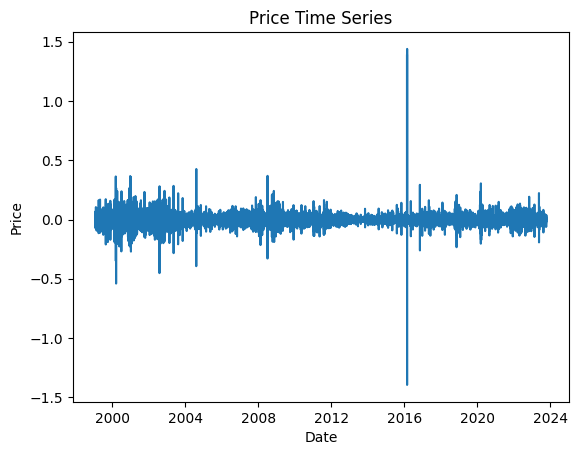

In [13]:
plt.plot(df.index, df['log_Price_diff2'])
plt.title('Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [14]:
auto_model = auto_arima(df['log_Price_diff2'], seasonal=False, stepwise=True, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=11.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-27231.638, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-29108.314, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=3.62 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-30766.534, Time=1.76 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-31421.643, Time=0.79 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-31931.624, Time=1.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-32250.977, Time=1.26 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=12.29 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=9.40 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-32248.977, Time=3.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 45.585 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9035

In [15]:
p, d, q = auto_model.order
model = ARIMA(df['log_Price_diff2'], order=(p, d, q))
model_fit = model.fit()

# Display a summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        log_Price_diff2   No. Observations:                 9035
Model:                 ARIMA(5, 0, 0)   Log Likelihood               16131.488
Date:                Sun, 22 Oct 2023   AIC                         -32248.977
Time:                        08:34:59   BIC                         -32199.215
Sample:                    01-25-1999   HQIC                        -32232.047
                         - 10-20-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.893e-06      0.000     -0.014      0.989      -0.000       0.000
ar.L1         -0.8254      0.004   -204.602      0.000      -0.833      -0.817
ar.L2         -0.7867      0.004   -183.108      0.0

In [16]:
# Forecast future log prices
forecast_period = 18  # Adjust the forecast horizon as needed
forecast = model_fit.get_forecast(steps=forecast_period)

# Extract the forecasted values and the associated standard errors
forecast_values = forecast.predicted_mean  # Define forecast_values
stderr = forecast.se_mean

# Reverse the second-order differencing
forecast_diff2 = np.cumsum(forecast_values)  # Reverse differencing

# Reverse the first-order differencing
forecast_diff1 = forecast_diff2 + df['log_Price'].iloc[-1]  # Start from the last value of the original series

# Invert the log transformation
forecast_original_scale = np.exp(forecast_diff1)

In [17]:
new_series = pd.concat([df["Price"],forecast_original_scale])

In [18]:
# Create a DataFrame with matching lengths for visualizing predictions
df_pred = pd.DataFrame({
    'Date': new_series.index,
    'Predictions': new_series,
    'Actual Prices': df["Price"]
})

# Create an interactive plot for visualizing future predictions
fig = px.line(df_pred, x='Date', y=['Predictions', 'Actual Prices'],
              labels={'value': 'Stock Price', 'variable': 'Data Type'},
              title="NVDA Stock Price Prediction")

fig.show()

In [21]:
predictions = new_series[-14:]
predictions

2023-10-25    414.449762
2023-10-26    413.005546
2023-10-27    412.653406
2023-10-28    412.769237
2023-10-29    412.684704
2023-10-30    413.056851
2023-10-31    413.151393
2023-11-01    412.847178
2023-11-02    412.820942
2023-11-03    412.899510
2023-11-04    412.918857
2023-11-05    412.951178
2023-11-06    412.928761
2023-11-07    412.882941
Freq: D, dtype: float64

In [22]:
predictions.to_csv("HUASHIAOHONG_Project_1(ARIMA).csv", index=False)